In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import theano
import keras.backend as K
from keras.models import load_model

Using Theano backend.


## Loading model

In [27]:
model = load_model("StandAlone/data/modelQ8.h5")

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/home/juillermo/anaconda2/lib/python2.7/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


### Visualize model

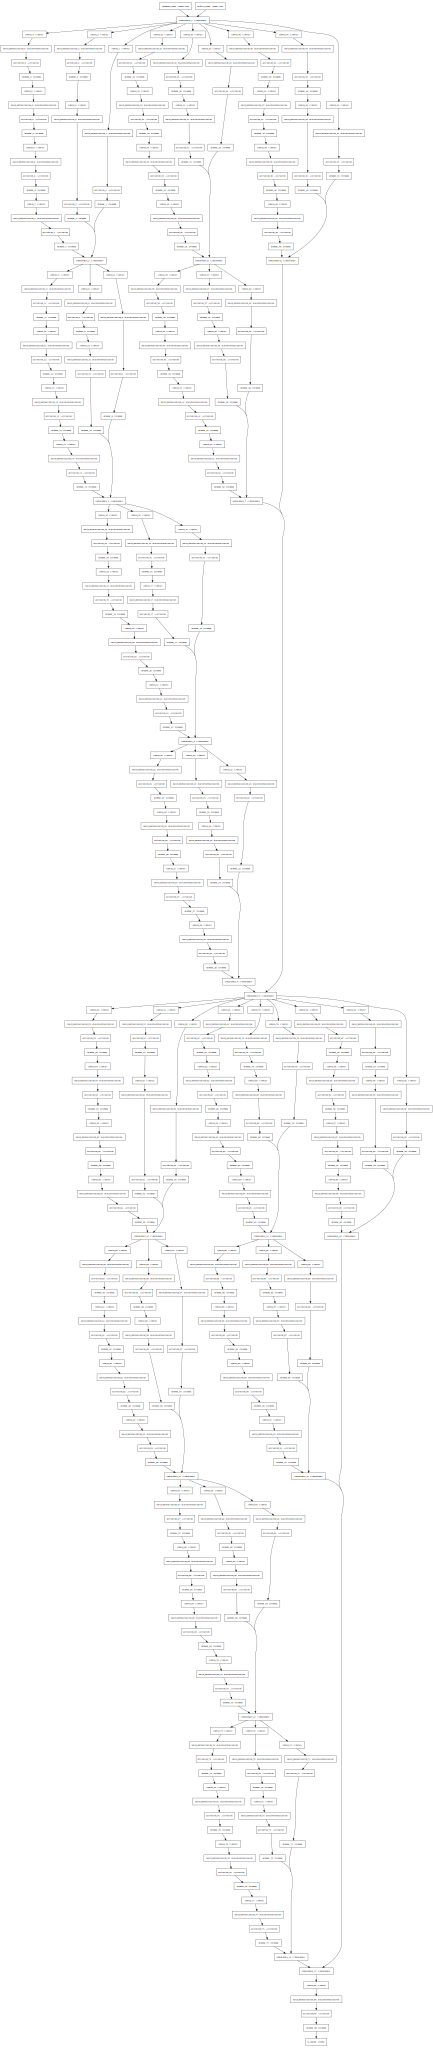

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model.png')

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     (None, 700, 21)      0                                            
__________________________________________________________________________________________________
profile_input (InputLayer)      (None, 700, 21)      0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 700, 42)      0           sequence_input[0][0]             
                                                                 profile_input[0][0]              
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 700, 100)     4300        concatenate_1[0][0]              
__________

In [9]:
output = model.get_layer(index=-1)
o_weights = output.get_weights()
print(o_weights[0].shape)
print(o_weights[1].shape)

(455, 9)
(9,)


In [24]:
type(model.outputs[0])

theano.tensor.var.TensorVariable

In [36]:
conv1d = model.get_layer(index=3)
conv1d.get_config()

{'activation': 'linear',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'data_format': 'channels_last',
 'dilation_rate': (1,),
 'filters': 100,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': u'uniform',
   'mode': u'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'kernel_size': (1,),
 'name': u'conv1d_4',
 'padding': u'same',
 'strides': (1,),
 'trainable': True,
 'use_bias': True}

-------------------------

## Loading data

In [28]:
from secondary_proteins_prediction import utils

TEST_PATH = 'secondary_proteins_prediction/data/cb513+profile_split1.npy.gz'
X_test_in = utils.load_gz(TEST_PATH)
X_test = np.reshape(X_test_in, (514, 700, 57))
del X_test_in
X_test = X_test[:, :, :].astype(theano.config.floatX)
labels_test = X_test[:, :, 22:30].astype('int32')
mask_test = X_test[:, :, 30].astype(theano.config.floatX)

a = np.arange(0, 21)
b = np.arange(35, 56)
c = np.hstack((a, b))
X_test = X_test[:, :, c]
    
# getting meta
seqlen = np.size(X_test, 1)
d = np.size(X_test, 2)
num_seq_test = np.size(X_test, 0)
del a, b, c

vals = np.arange(0, 8)
labels_new = np.zeros((num_seq_test, seqlen))
for i in xrange(np.size(labels_test, axis=0)):
    labels_new[i, :] = np.dot(labels_test[i, :, :], vals)
labels_new = labels_new.astype('int32')
labels_test = labels_new

### ADDING BATCH PADDING ###

#X_add = np.zeros((126, seqlen, d))
#label_add = np.zeros((126, seqlen))
#mask_add = np.ones((126, seqlen))

#X_test = np.concatenate((X_test, X_add), axis=0).astype(theano.config.floatX)
#labels_test = np.concatenate((labels_test, label_add), axis=0).astype('int32')
#mask_test = np.concatenate((mask_test, mask_add), axis=0).astype(theano.config.floatX)

#return X_test, mask_test, labels_test, num_seq_test
print "X_test.shape", X_test.shape
print "label_test.shape", labels_test.shape

X_test.shape (514, 700, 42)
label_test.shape (514, 700)


In [29]:
# Decoding info

# Defined twice!!
aaMap_fang = {'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12,
         'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19, 'NoSeq': 20}

def decode(coded_seq):
    # Defined twice!!
    aaMap_fang = {'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12,
         'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19, 'NoSeq': 20}
    coded_seq = np.argmax(coded_seq, axis=1)
    decoded_seq = []
    
    for number in coded_seq:
        for am, code in aaMap_fang.iteritems():
            if code == number and am is not 'NoSeq':
                decoded_seq.append(am)
    
    return "".join(decoded_seq)

# Permutation from Troyanska's pssm arranging (ACDEFGHIKLMNPQRSTVWXY) to Fang's ('ARNDCQEGHILKMFPSTWYV NoSeq')
sorted_fang = sorted(aaMap_fang.keys(), key= lambda letter: aaMap_fang[letter])

aaMap = ['A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'N', 'Q', 'P', 'S', 'R', 'T', 'W', 'V', 'Y', 'X']
pssm = 'ACDEFGHIKLMNPQRSTVWXY'
aaMap_jurtz = {amino:i for i, amino in enumerate(aaMap)}
pssm_jurtz = {amino:i for i, amino in enumerate(pssm)}

index_am   = np.array([aaMap_jurtz[letter] for letter in sorted_fang if letter is not 'NoSeq'])
index_pssm = np.array([ pssm_jurtz[letter] for letter in sorted_fang if letter is not 'NoSeq'])

X_test_am   = X_test[:,:,index_am]
X_test_pssm = X_test[:,:,index_pssm + 21]

# Add NoSeq class
X_test_am   = np.concatenate([X_test_am,   mask_test[:,:,None]], axis=2)
X_test_pssm = np.concatenate([X_test_pssm, mask_test[:,:,None]], axis=2)

In [26]:
np.min(labels_test)

0

------------------------- 

## Make predictions

In [41]:
from StandAlone.bin.executable import convertPredictQ8Result2HumanReadable

In [30]:
predictions = model.predict([X_test_am[0:2], X_test_pssm[0:2]])
predictions.shape

(2, 700, 9)

In [43]:
ssConvertMap = {0: 'C', 1: 'B', 2: 'E', 3: 'G', 4: 'I', 5: 'H', 6: 'S', 7: 'T', 8: ''}
window = 29 # 29 aminoacids per side

for target_class in range(8):
    print "Class ", ssConvertMap[target_class]

    max_target = np.argmax( predictions[:, :, target_class] )
    max_target = np.unravel_index( max_target, predictions.shape[0:2] )
    seq = max_target[0]
    pos = max_target[1]
    
    print "max_target", max_target
    print "value: ", predictions[seq, pos, target_class]

    if pos >= window:
        init = pos - window
    else:
        init = 0
    end = pos + window + 1
    
    gato = decode( X_test_am[seq] )
    print "Aminoacids ", gato[ init:pos ], gato[ pos ], gato[ pos+1:end ]
    perro = convertPredictQ8Result2HumanReadable( predictions[seq] )
    print "Predictions", perro[init:pos], perro[pos], perro[pos+1:end]
    conejo = "".join([ssConvertMap[el] for el in labels_test[seq]])
    print "True labels", conejo[init:pos], conejo[pos], conejo[pos+1:end], "\n"
    
    gradients = theano.gradient.grad(model.outputs[0][seq,pos,target_class], wrt=[model.inputs[0], model.inputs[1]])
    get_gradients = K.function(inputs=[model.inputs[0], model.inputs[1], K.learning_phase()], outputs=gradients)
    inputs = [X_test_am[seq,...], X_test_pssm[seq,...], 0]
    inputs = [inputs[0][None,...], inputs[1][None,...], inputs[2]]
    grads = get_gradients(inputs)
    grads = np.array(grads)
    plt.plot(np.sum(np.sum(abs(grads[:,0,init:end,:]), axis=2), axis=0)) # Aminoacid importance

Class  C
max_target (0, 66)
value:  1.0
Aminoacids  DNKGNRVQITNVTSKVVTSNIQLLLNTRN I 
Predictions CTTSCEEEEEETTSSEEEEEEEEEEEEEC C 
True labels CSSSSCEEEEETTSHHHHHTBCCBCCGGG C CCCCCCCCCCCCCCCCCCCCCCCCCCCCC

Class  B
max_target (0, 29)
value:  0.33957827
Aminoacids  VPSLATISLENSWSGLSKQIQLAQGNNGI F RTPIVLVDNKGNRVQITNVTSKVVTSNIQ
Predictions CCCHHHHHHHHHHHHHHHHHHHHHTTTCC C SSCEEEECTTSCEEEEEETTSSEEEEEEE
True labels CCCHHHHHHHHHHHHHHHHHHHHTTTTTE E EEEEEECCSSSSCEEEEETTSHHHHHTBC

Class  E
max_target (1, 67)
value:  0.9988894
Aminoacids  EKGVFDDEKIAELLTKLGRDTQIGLTMPQ V FAPDGSHIGGFDQLREYFK
Predictions GTTCCCHHHHHHHHHHHTCCCCSCCCCCE E ECTTSCEEESHHHHHHHHC
True labels BTTBCCHHHHHHHHHHHTCSCSSSCCSCE E ECTTSCEEESHHHHHHHTCCCCCCCCCCC

Class  G
max_target (1, 38)
value:  0.4486763
Aminoacids  NIHKCVYCDNAKRLLTVKKQPFEFINIMP E KGVFDDEKIAELLTKLGRDTQIGLTMPQV
Predictions TGTTCHHHHHHHHHHHHTTCCCEEEECCG G TTCCCHHHHHHHHHHHTCCCCSCCCCCEE
True labels TTSCCHHHHHHHHHHHHTTCCEEEEESCS B TTBCCHHHHHHHHHHHTCSCSSSCCSCEE

Class  

### Compute gradients

In [53]:
#weights = model.trainable_weights # weight tensors
gradients = theano.gradient.grad(model.outputs[0][seq,pos,7], wrt=[model.inputs[0], model.inputs[1]])
#gradients = theano.gradient.jacobian(model.outputs[0][seq,pos,:], wrt=model.inputs)
#gradients = K.gradients(model.predict, model.inputs)
#gradients = K.gradients(model.total_loss, model.inputs) # gradient tensors
#input_tensors = model.inputs + model.sample_weights + model.targets + [K.learning_phase()]
#get_gradients = K.function(inputs=input_tensors, outputs=gradients)

In [106]:
get_gradients = K.function(inputs=[model.inputs[0], model.inputs[1], K.learning_phase()], outputs=gradients)

In [109]:
inputs = [X_test_am[seq,...], X_test_pssm[seq,...], 0]
inputs = [inputs[0][None,...], inputs[1][None,...], inputs[2]]
grads = get_gradients(inputs)
grads = np.array(grads)

(2, 1, 700, 21)

In [94]:
grads[:,seq,init:end,:]

array([[[-1.30143346e-12, -8.42253264e-12, -1.02235729e-11, ...,
         -4.55312264e-12,  3.60481393e-12,  1.45631705e-12],
        [ 8.03531408e-11, -1.39723259e-12,  5.40718893e-11, ...,
          7.32759756e-11,  3.53763997e-11, -6.99510762e-12],
        [-1.08706572e-10, -1.86981541e-10, -3.23495813e-10, ...,
         -3.27680272e-10,  1.90031033e-10,  6.79268100e-11],
        ...,
        [ 2.25766129e-13, -5.01347390e-13,  5.91065608e-13, ...,
          2.65183654e-13, -2.47494083e-14, -2.01070199e-13],
        [ 5.14729149e-14,  9.01710686e-14,  1.03888347e-13, ...,
          1.73511243e-14, -4.54712290e-14, -8.17424199e-14],
        [ 6.72787047e-15, -6.02380482e-15,  1.18631343e-14, ...,
          6.08384802e-15,  2.71091116e-15,  9.20786139e-15]],

       [[ 1.54587725e-12,  3.38451923e-12,  8.48274055e-12, ...,
         -1.50026415e-11, -3.45101660e-12, -8.26000780e-14],
        [ 2.44336253e-11, -1.18907606e-10,  8.05771075e-12, ...,
          6.94067156e-12,  6.10600320e

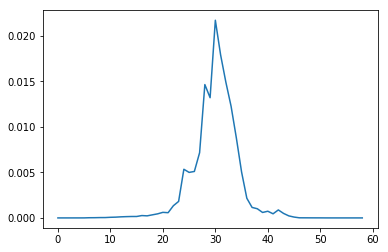

In [127]:
plt.plot(np.sum(np.sum(abs(grads[:,0,init:end,:]), axis=2), axis=0)) # Aminoacid importance
#plt.plot(grads[1,0,pos,:])

In [123]:
abs(grads[:,seq,init:end,:]).shape

(2, 59, 21)

In [5]:
import pickle
with open(("test_saliency/saliencies.pkl"), "r") as f:
    saliencies = pickle.load(f)

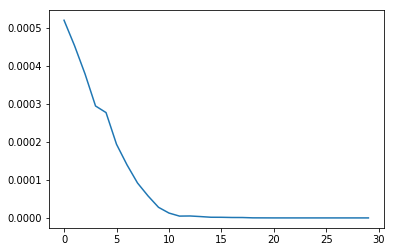

In [11]:
plt.plot(saliencies[0,0]["grads"])